In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# from google.colab import drive
# drive.mount('/content/drive')
# out_filename = '/content/drive/My Drive/Colab Notebooks/Stock_Market_Data.csv'

In [87]:
# Stock market data loading from yahoo and setting data frame
plt.style.use("fivethirtyeight")
FIG_SIZE=(14, 7)

end = datetime.now()
start = datetime(end.year - 9, end.month, end.day) 
df = DataReader('AAPL', 'yahoo', start, end)
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03,2264.000000
mean,37.495863,36.727595,37.111535,37.125550,2.322944e+08,35.170897
std,22.509564,21.834981,22.183936,22.187304,1.803147e+08,22.736771
min,13.255357,12.975715,13.157857,12.984643,2.880380e+07,11.110251
25%,22.128393,21.644464,21.974910,21.919910,1.112856e+08,18.969082
50%,29.528750,29.059999,29.322500,29.290001,1.694158e+08,27.167540
75%,45.122499,44.409999,44.741250,44.729374,2.886909e+08,43.155459
max,137.979996,130.529999,137.589996,134.179993,1.506120e+09,133.948898


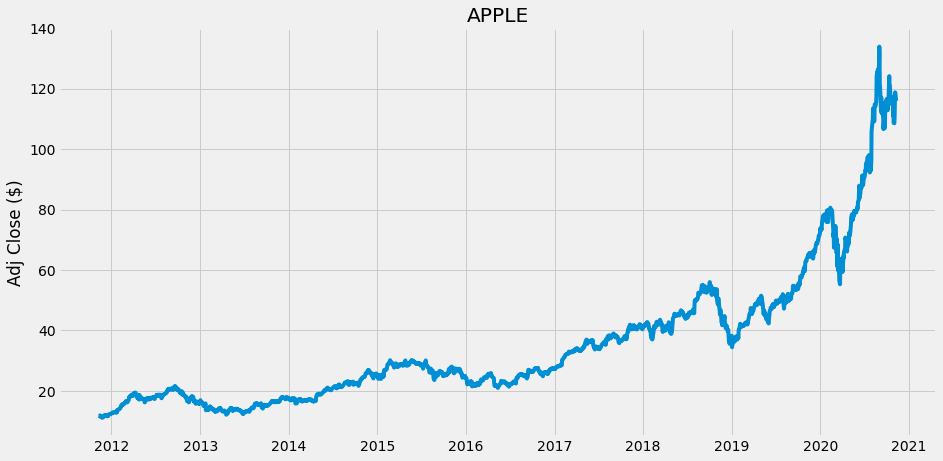

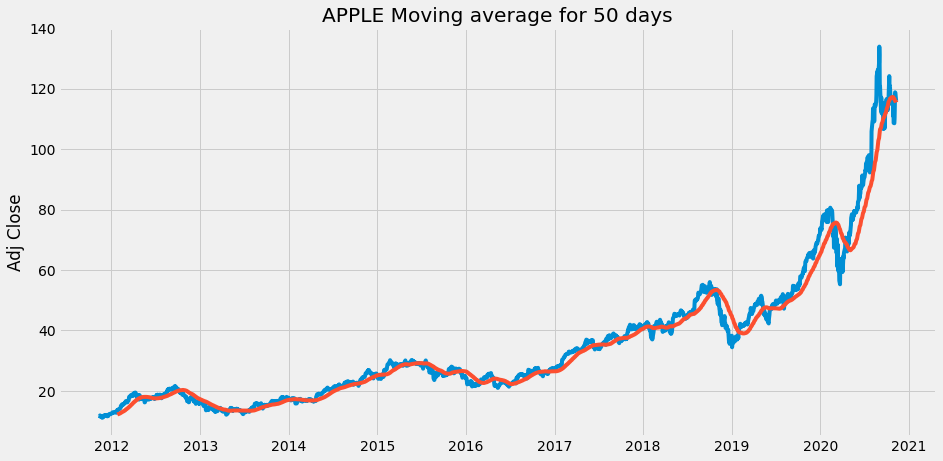

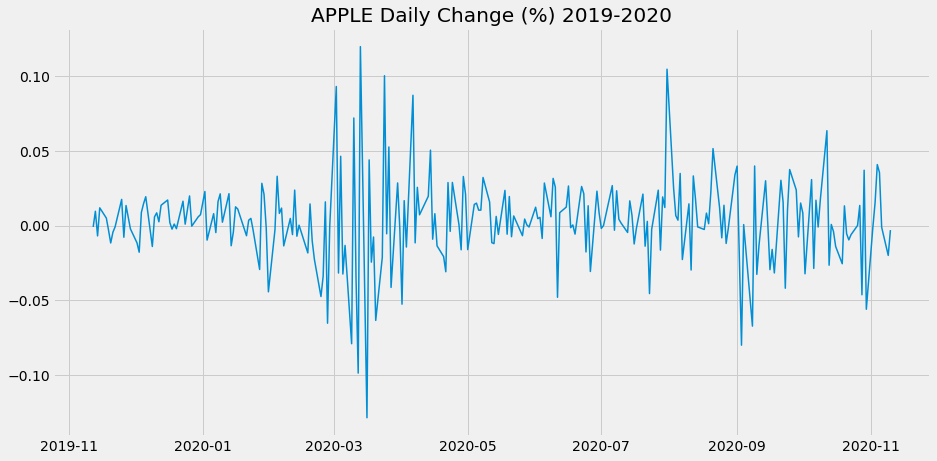

In [119]:
#@title
# Closing price diagram

plt.figure(figsize=FIG_SIZE)
plt.plot(df['Adj Close'])
plt.ylabel('Adj Close ($)')
plt.title("APPLE")
plt.show()

# Moving average

ma_day = [50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

plt.figure(figsize=FIG_SIZE)
plt.plot(df[['Adj Close', 'MA for 50 days']])
plt.ylabel('Adj Close')
plt.title("APPLE Moving average for 50 days")
plt.show()

# Daily Change over time
df['Daily Change'] = df['Adj Close'].pct_change()

plt.figure(figsize=FIG_SIZE)
plt.plot(df['Daily Change'][int(8/9*len(df)):len(df)], linewidth=1.5)
plt.title("APPLE Daily Change (%) 2019-2020")
plt.show()

In [122]:
# data reshapening
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# data conv to np array
data = df.filter(['Close']).values
# data normalization
data = scaler.fit_transform(data)
# train and test creation
#####################
TEST_TRAIN_SPLIT = 0.8
TIME_STEPS = 50
#####################
X_train, Y_train = [], []
X_test, Y_test   = [], []

split_val = int(len(data)*TEST_TRAIN_SPLIT)
for i in range(0,split_val-TIME_STEPS):
    X_train.append(data[i : i+TIME_STEPS, 0])
    Y_train.append(data[i+TIME_STEPS, 0])
for i in range(split_val-TIME_STEPS,len(data)-TIME_STEPS):
    X_test.append(data[i : i+TIME_STEPS, 0])
    Y_test.append(data[i+TIME_STEPS, 0])

X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [133]:
# LSTM modeling

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, batch_size=1, epochs=2)

Epoch 1/2
1761/1761 [==============================] - 38s 21ms/step - loss: 4.5670e-04
Epoch 2/2
1761/1761 [==============================] - 38s 21ms/step - loss: 2.6989e-04


In [137]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(((predictions - Y_test) ** 2)))
rmse

75.4761943302993

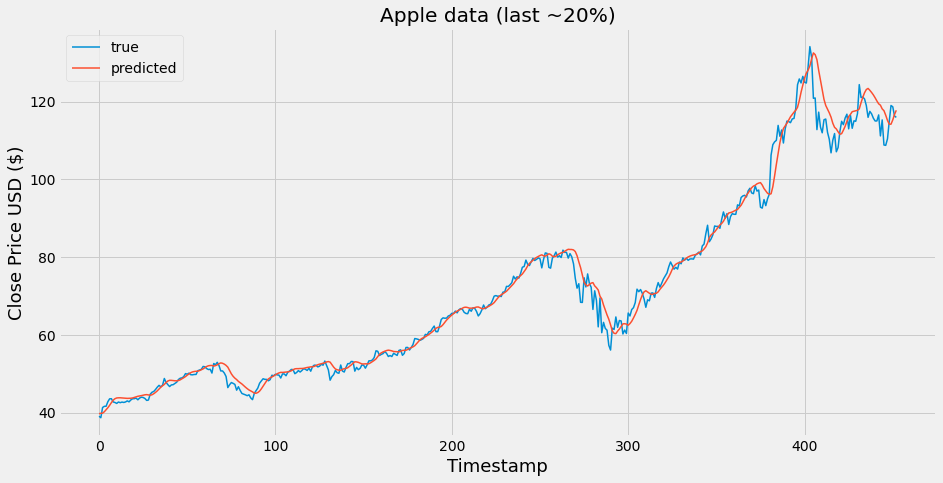

In [140]:
# Plot the data
train = scaler.inverse_transform(data[:split_val])
valid = scaler.inverse_transform(data[split_val:])
plt.figure(figsize=FIG_SIZE)
# plt.plot(train, linewidth=1.5)
plt.plot(valid, linewidth=1.5)
plt.plot(predictions, linewidth=1.5)
plt.title('Apple data (last ~20%)')
plt.xlabel('Timestamp', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['true','predicted'], loc="upper left")
# plt.gca().set_xlim([250,300])
plt.show()